# ㅇ

In [ ]:
!pip install CatBoost
!pip install seaborn
!pip install SHAP

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
import os
from collections import Counter
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(110) # Seed 고정

In [ ]:
ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
train_df = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

In [ ]:
train_df = train_df.drop(columns=['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'])
test_df = test_df.drop(columns=['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'])

In [ ]:
# 모두 결측치 이거나, 모두 같은 값인 경우 drop
# test는 train과 버려지는 열이 같도록 조정

def drop_constant_or_all_nan_columns(train_df: pd.DataFrame, test_df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    # Identify columns in train_df where all values are NaN
    all_nan_columns = train_df.columns[train_df.isna().all()].tolist()

    # Identify columns in train_df where all values are the same
    constant_columns = [col for col in train_df.columns if train_df[col].nunique() == 1]

    # Combine columns to drop
    columns_to_drop = list(set(all_nan_columns + constant_columns))

    # Drop the identified columns from both train_df and test_df
    train_df = train_df.drop(columns=columns_to_drop)
    test_df = test_df.drop(columns=columns_to_drop)

    return train_df, test_df

train_df, test_df = drop_constant_or_all_nan_columns(train_df, test_df)

In [ ]:
# Mapping 'Target' to integer
target_mapping = {'Normal': 0, 'AbNormal': 1}
inverse_target_mapping = {v: k for k, v in target_mapping.items()}
train_df['target'] = train_df['target'].map(target_mapping)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


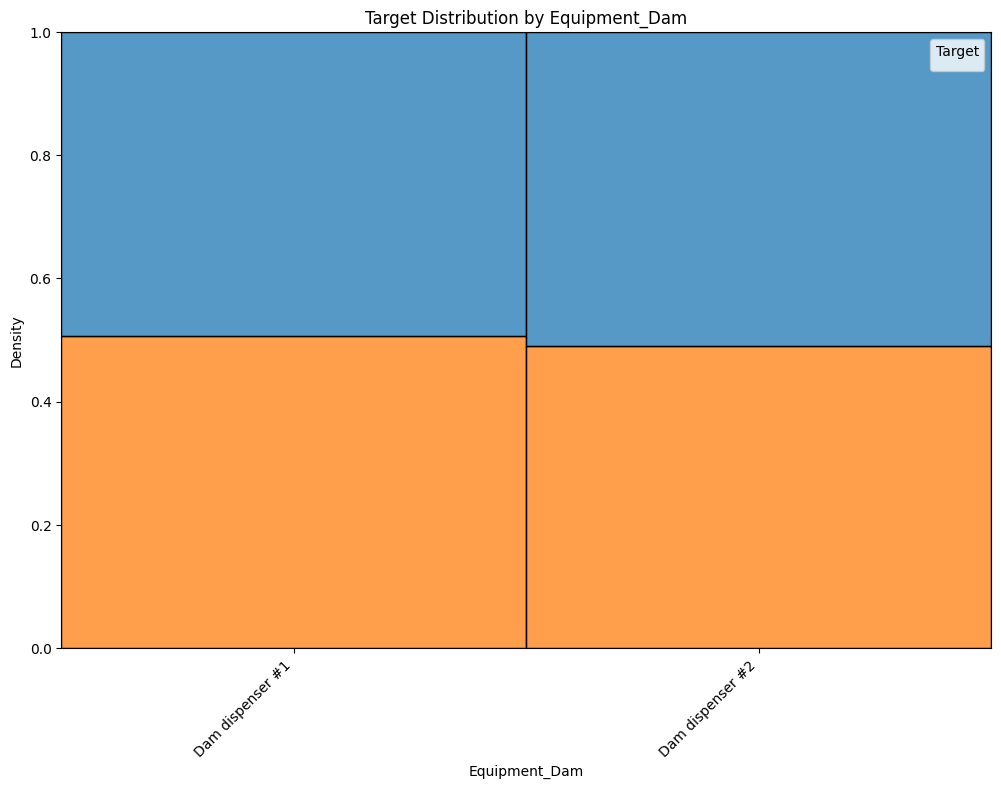

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


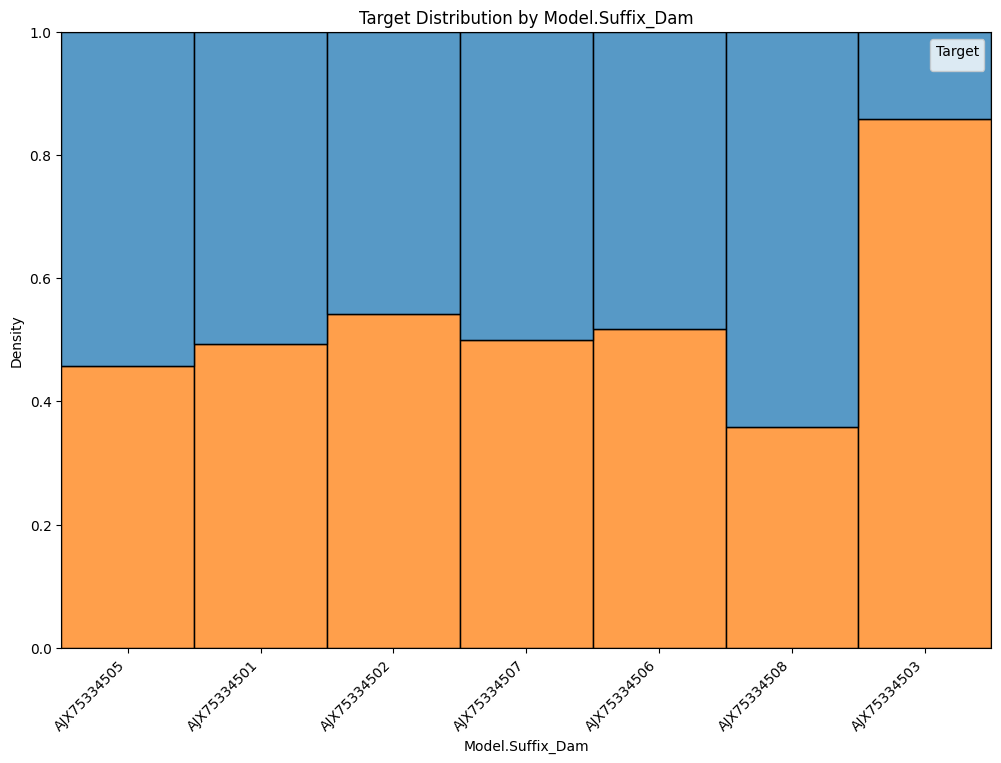

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


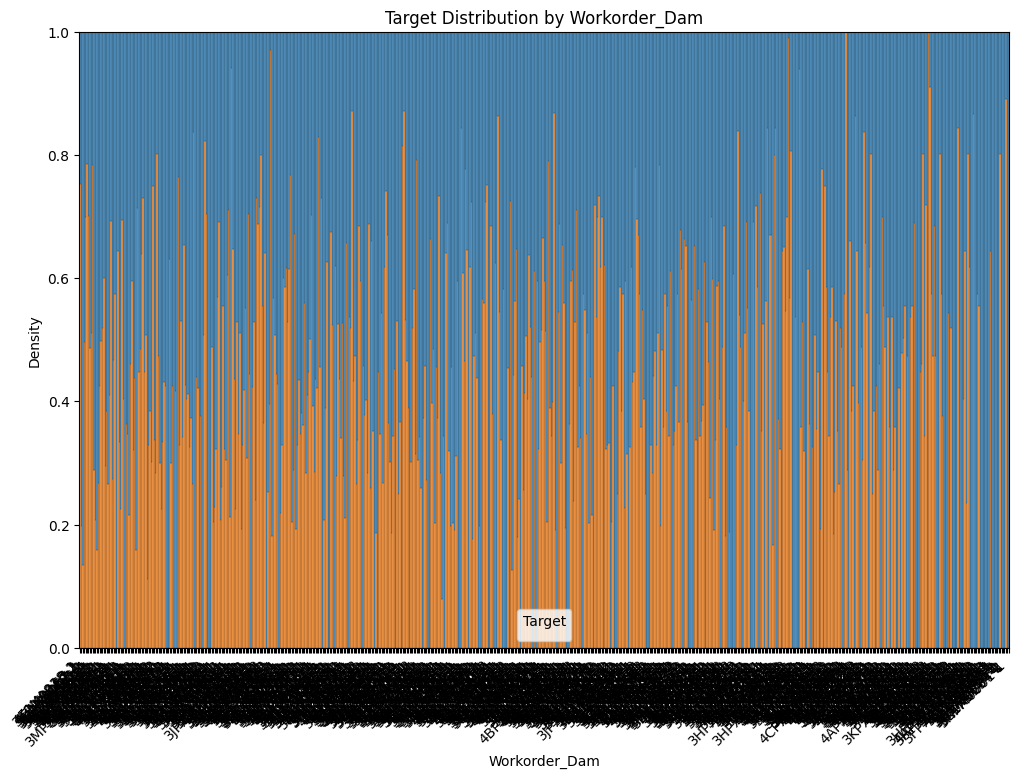

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


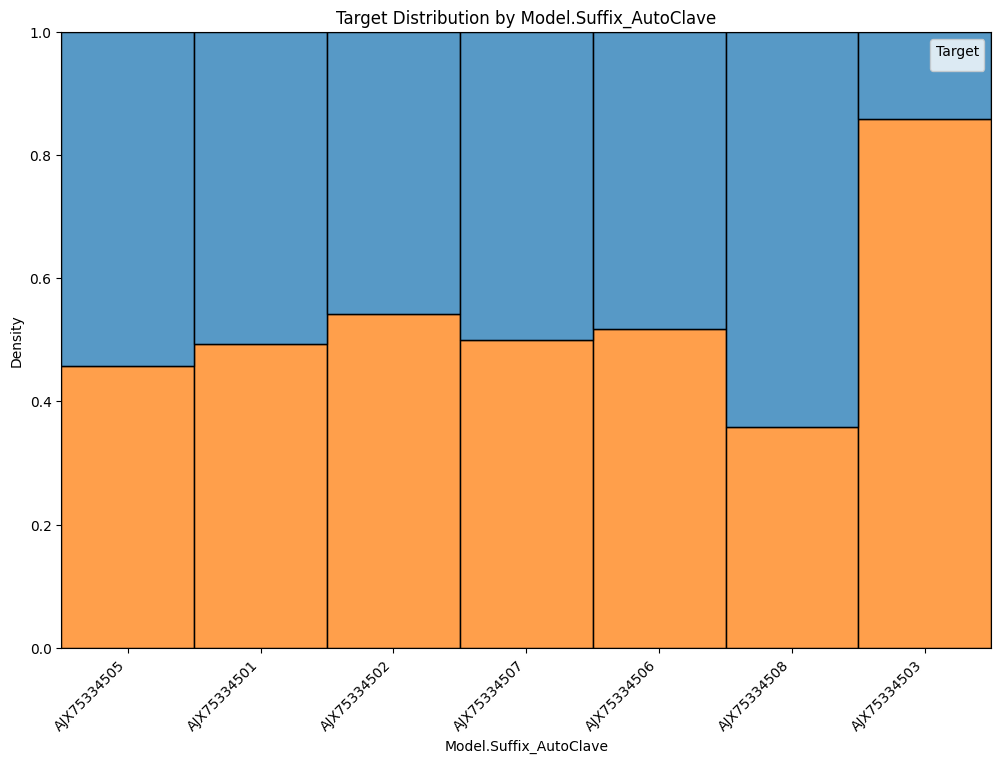

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


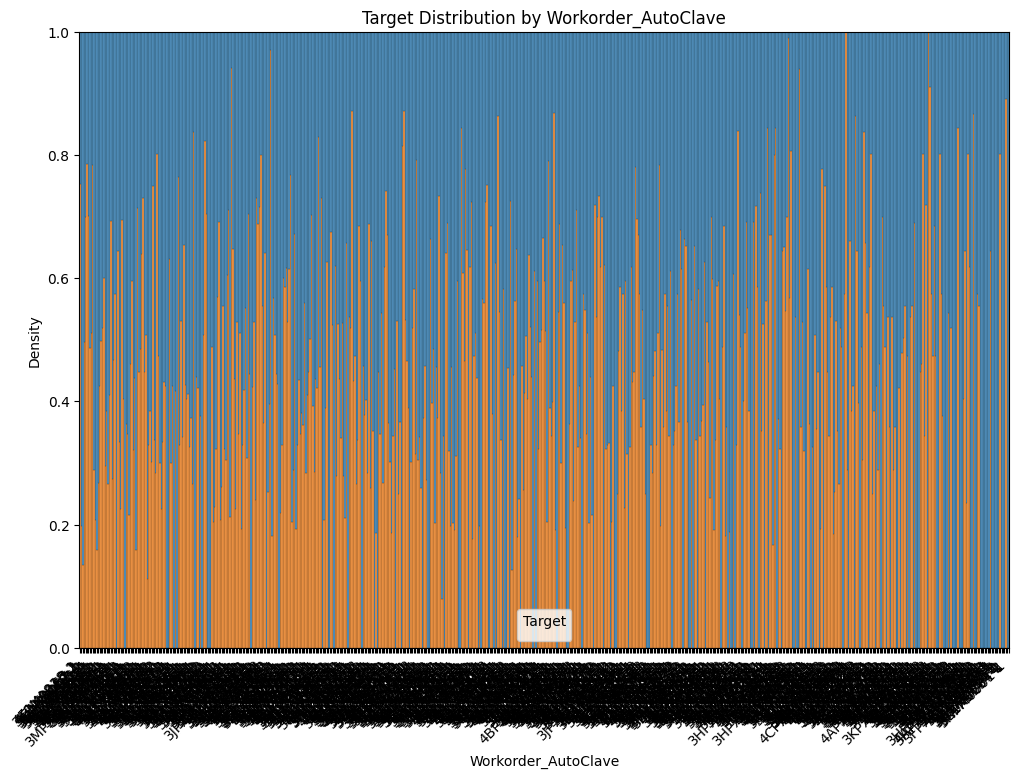

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


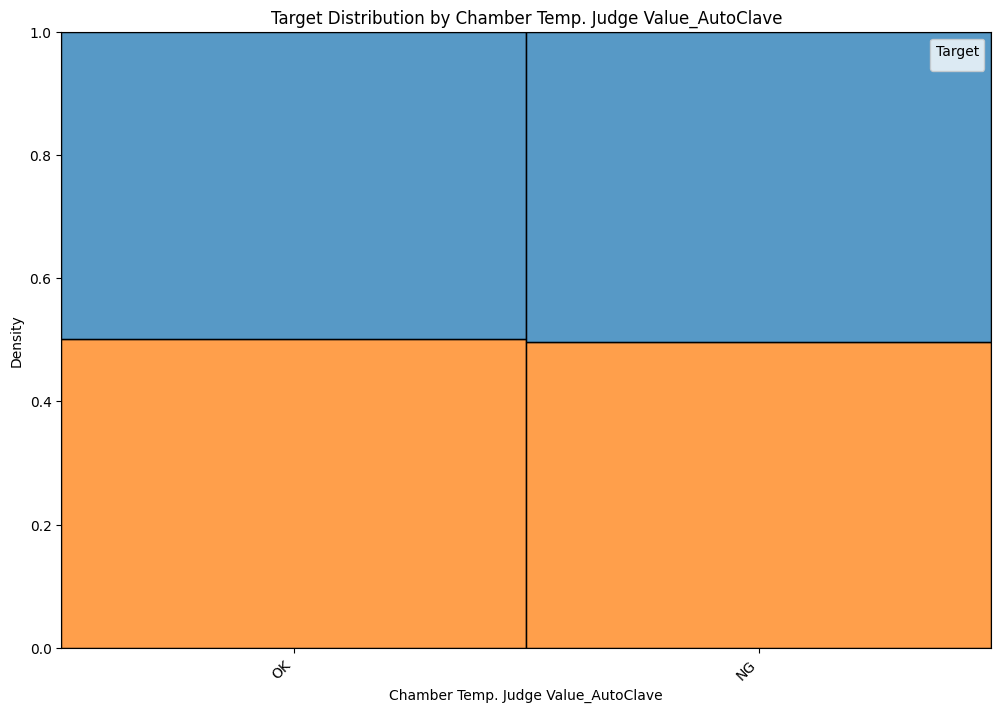

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


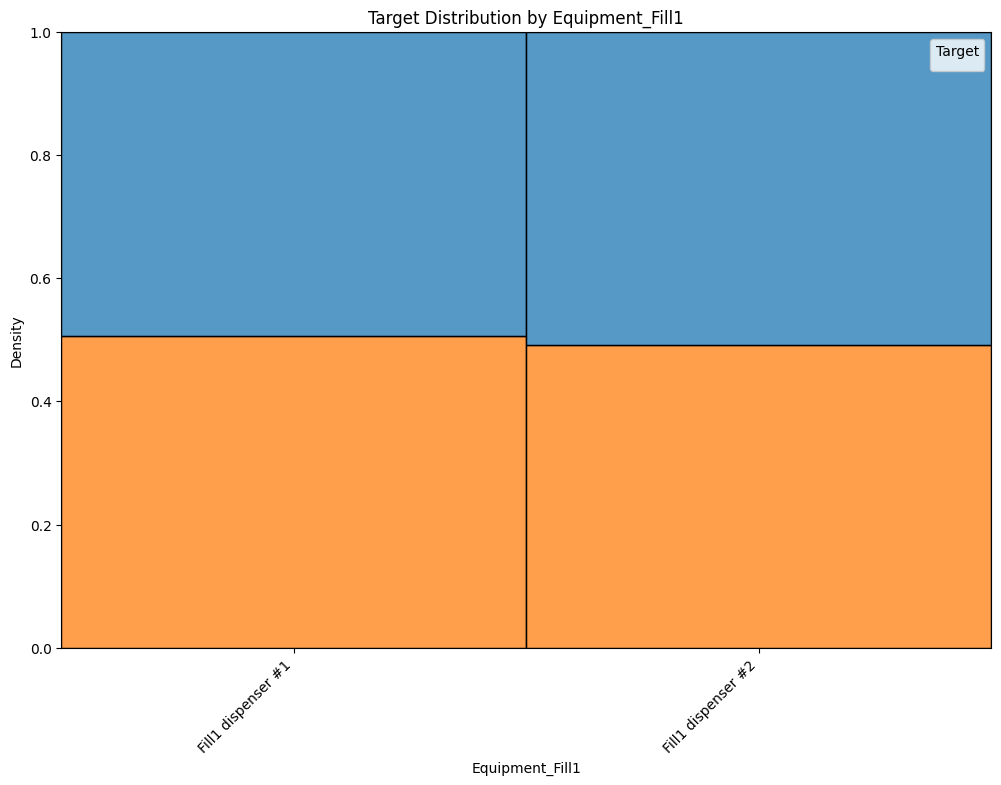

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


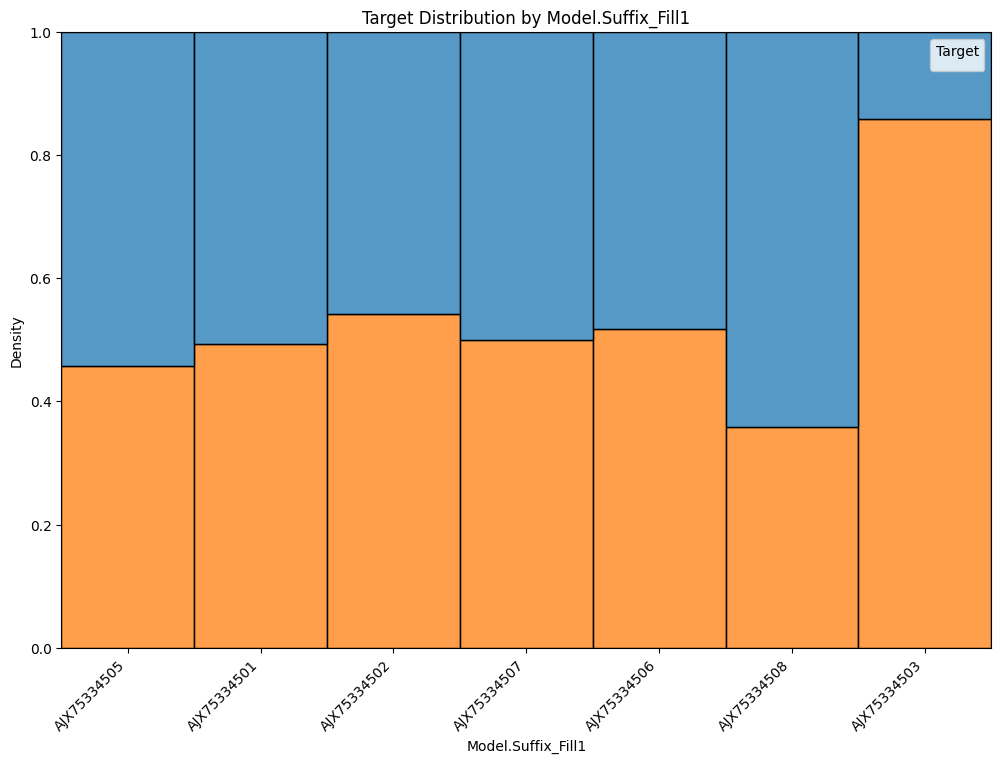

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


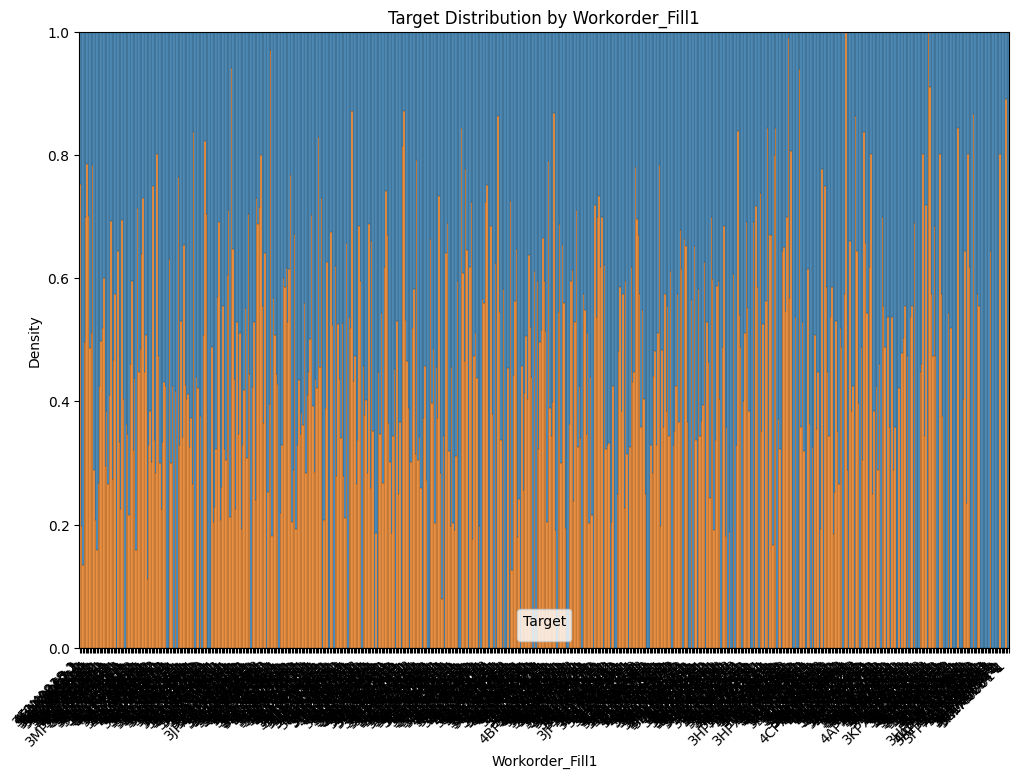

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


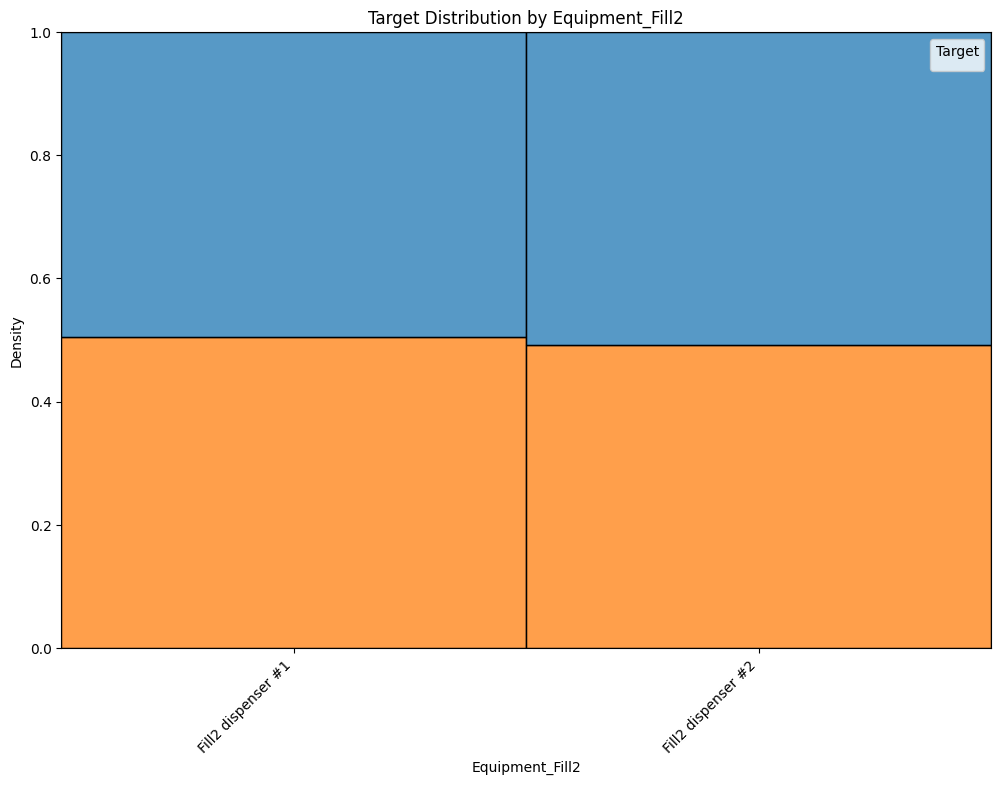

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


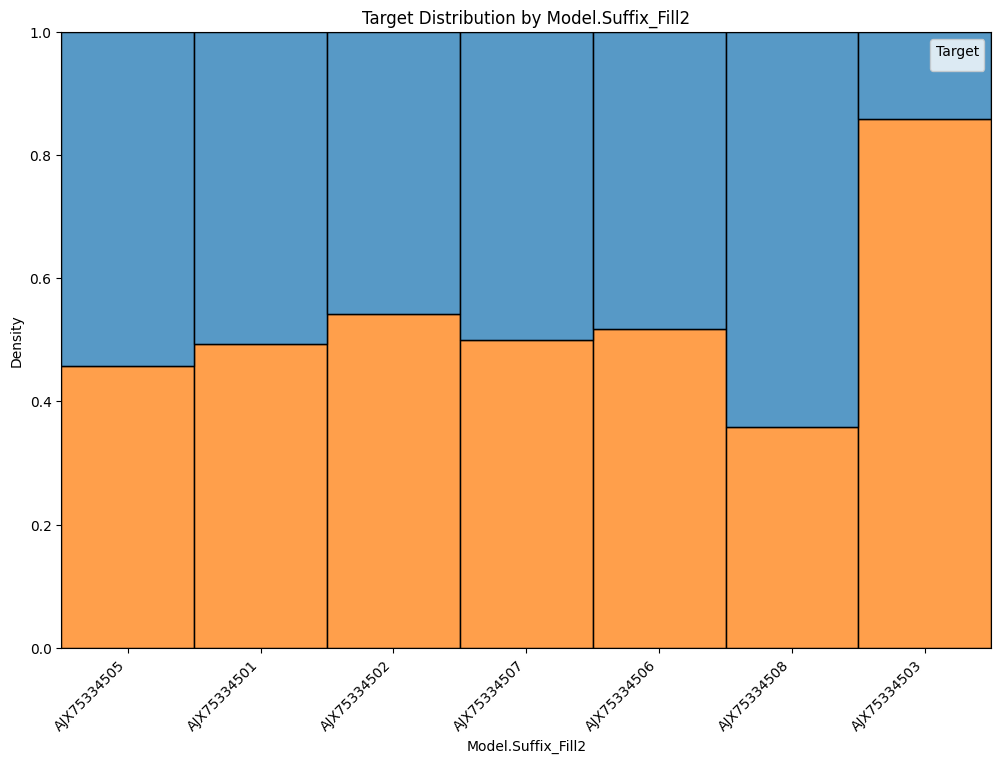

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


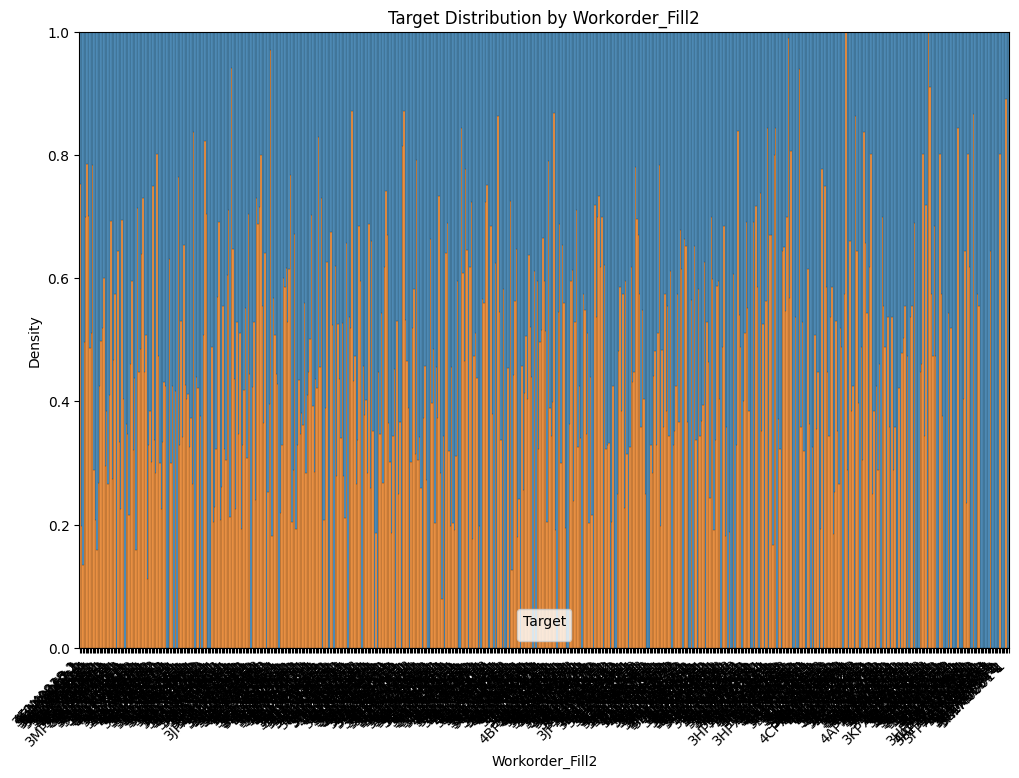

Features to drop: ['Equipment_Dam', 'Chamber Temp. Judge Value_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2']
Number of features to drop: 4


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# 카테고리컬 변수 식별
categorical_columns = train_df.select_dtypes(include=['object', 'category']).columns

# 타겟 분포 차이가 작은 변수들을 저장할 리스트
features_to_drop = []

# 각 카테고리컬 변수별 target 분포 시각화 및 chi-square test
for col in categorical_columns:
    plt.figure(figsize=(12, 8))
    sns.histplot(
        data=train_df,
        x=col,
        hue='target',
        multiple='fill',  # 상대도수로 표시
        stat="density",
        common_norm=False
    )
    plt.title(f'Target Distribution by {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.xticks(rotation=45, ha='right')  # x축 레이블 회전
    plt.legend(title='Target')
    plt.show()

    # 카이제곱 검정 (chi-square test)
    contingency_table = pd.crosstab(train_df[col], train_df['target'])
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # p-value가 높은 경우 (임계값보다 큰 경우) 분포 차이가 없다고 간주하여 드롭
    if p > 0.05:  # p-value 임계값은 0.05로 설정
        features_to_drop.append(col)

# 드롭할 변수들 출력
print(f"Features to drop: {features_to_drop}")
print(f"Number of features to drop: {len(features_to_drop)}")

# train_df와 test_df에서 해당 변수들 드롭
train_df = train_df.drop(columns=features_to_drop)
test_df = test_df.drop(columns=features_to_drop)


In [ ]:
from scipy.stats import spearmanr, pearsonr
import itertools

# 카테고리 및 수치형 변수 분리
categorical_columns = train_df.select_dtypes(include=['category', 'object']).columns

# 카테고리 변수 처리 (Spearman 상관계수)
train_df_encoded = train_df.copy()

# 카테고리 변수를 순서형 숫자로 변환
for col in categorical_columns:
    train_df_encoded[col] = train_df_encoded[col].astype('category').cat.codes

to_remove = set()

# 스피어만 상관계수 계산 및 제거할 변수 식별
for col1, col2 in itertools.combinations(categorical_columns, 2):
    corr, _ = spearmanr(train_df_encoded[col1], train_df_encoded[col2])
    if corr >= 0.9 or corr <= -0.9:
        # 상관계수가 높은 경우 두 번째 변수를 제거할 변수로 표시
        to_remove.add(col2)

# 변수 제거
train_df = train_df.drop(columns=to_remove)
test_df = test_df.drop(columns=to_remove)


to_remove

{'Model.Suffix_AutoClave',
 'Model.Suffix_Fill1',
 'Model.Suffix_Fill2',
 'Workorder_AutoClave',
 'Workorder_Fill1',
 'Workorder_Fill2'}

In [ ]:
from scipy.stats import ttest_ind

# Numeric 컬럼 식별
numeric_columns = train_df.select_dtypes(include=['float64', 'int64']).columns

# 피어슨 상관계수 계산
correlation_matrix = train_df[numeric_columns].corr()

# 상관계수 절대값이 일정 기준 이상인 컬럼 쌍 추출 (예: 0.999 이상)
threshold = 0.999
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            high_corr_pairs.append((colname_i, colname_j))

# 상관계수가 높은 컬럼 쌍에서 normal과 abnormal 간 T-test로 분포 차이 분석
cols_to_drop = []

for (col_i, col_j) in high_corr_pairs:
    # T-test 수행
    normal_i = train_df[train_df['target'] == 0][col_i]
    abnormal_i = train_df[train_df['target'] == 1][col_i]
    normal_j = train_df[train_df['target'] == 0][col_j]
    abnormal_j = train_df[train_df['target'] == 1][col_j]

    # T-test for independent samples
    t_stat_i, p_value_i = ttest_ind(normal_i, abnormal_i, equal_var=False)
    t_stat_j, p_value_j = ttest_ind(normal_j, abnormal_j, equal_var=False)

    # p-value가 높아 분포 차이가 유사한 경우 두 번째 컬럼을 제거
    if abs(t_stat_i - t_stat_j) < 0.05:  # T-statistic 차이가 거의 없는 경우
        cols_to_drop.append(col_j)

# 중복 제거
cols_to_drop = list(set(cols_to_drop))

# 제거할 컬럼들 출력
print(len(cols_to_drop))
print(f"Columns to drop: {cols_to_drop}")

# 컬럼 제거
train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)


53
Columns to drop: ['Head Clean Position Y Collect Result_Dam', 'HEAD Standby Position Z Collect Result_Fill2', 'Head Clean Position Z Collect Result_Dam', 'Stage1 Line1 Distance Speed Collect Result_Dam', 'HEAD Standby Position X Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1', 'HEAD Standby Position X Collect Result_Fill2', 'CURE END POSITION Θ Collect Result_Dam', 'Stage1 Line3 Distance Speed Collect Result_Dam', 'Head Purge Position X Collect Result_Fill1', 'Stage2 Line1 Distance Speed Collect Result_Dam', 'Head Purge Position X Collect Result_Fill2', 'HEAD Standby Position Y Collect Result_Dam', 'Head Clean Position X Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2', 'Head Clean Position X Collect Result_Dam', 'Head Clean Position Y Collect Result_Fill2', 'Head Clean Position Z Collect Result_Fill1', 'Receip No Collect Result_Dam', 'Head Clean Position Z Collect Result_Fill2', 'HEAD NORMAL COORDINATE Y AXIS(St

In [ ]:
# 데이터 준비
X = train_df.drop(columns=['target'])
y = train_df['target']
X_test = test_df.drop(columns=['Set ID', 'target'])

# 카테고리 변수 식별
cat_features = [col for col in X.columns if X[col].dtype == 'object' or X[col].dtype.name == 'category']

# 카테고리 변수를 문자열로 변환
for col in cat_features:
    X[col] = X[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Pool 생성
train_pool = Pool(X, y, cat_features=cat_features)

# 모델 생성 및 학습
model = CatBoostClassifier(
    iterations=400,
    learning_rate=0.01,
    depth=6,
    l2_leaf_reg=3.0,
    loss_function='Logloss',
    eval_metric='F1',
    random_seed=110,
    class_weights=class_weights_dict,
    verbose=100
)

model.fit(train_pool)


0:	learn: 0.6232968	total: 37.5ms	remaining: 15s
100:	learn: 0.6248722	total: 2.44s	remaining: 7.23s
200:	learn: 0.6242095	total: 4.54s	remaining: 4.5s
300:	learn: 0.6270642	total: 6.48s	remaining: 2.13s
399:	learn: 0.6348750	total: 8.41s	remaining: 0us


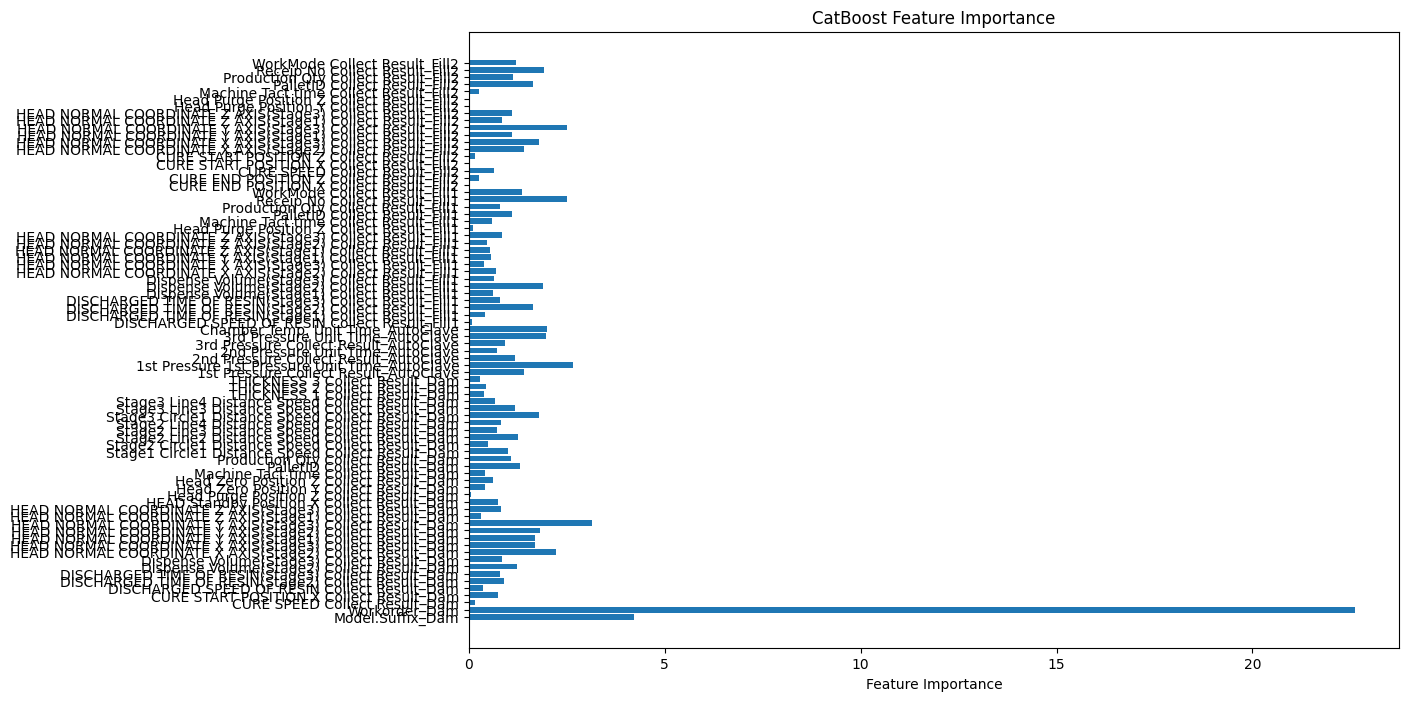

                                                   Feature  Importance
                                             Workorder_Dam   22.607742
                                          Model.Suffix_Dam    4.215228
  HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam    3.136759
             1st Pressure 1st Pressure Unit Time_AutoClave    2.651947
                            Receip No Collect Result_Fill1    2.496379
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2    2.494089
  HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam    2.212581
                         Chamber Temp. Unit Time_AutoClave    1.986505
                          3rd Pressure Unit Time_AutoClave    1.963471
                            Receip No Collect Result_Fill2    1.924129
              Dispense Volume(Stage2) Collect Result_Fill1    1.898717
  HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam    1.805861
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2    1.800797
      

In [ ]:
# Feature Importance 출력
import matplotlib.pyplot as plt

# CatBoost에서 제공하는 feature importance 가져오기
feature_importances = model.get_feature_importance(train_pool)
feature_names = X.columns

# Feature Importance를 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_names, feature_importances, align='center')
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.show()

# Feature Importance를 데이터프레임으로 저장하여 출력
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 전체 내용을 출력하도록 설정
print(importance_df.to_string(index=False))

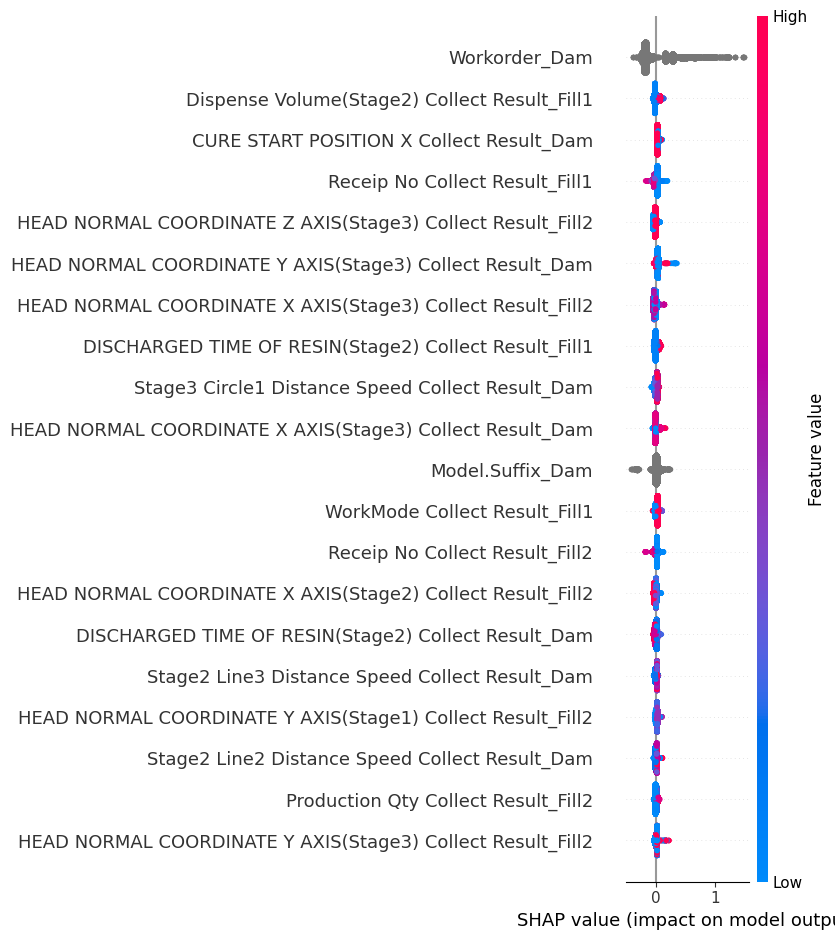

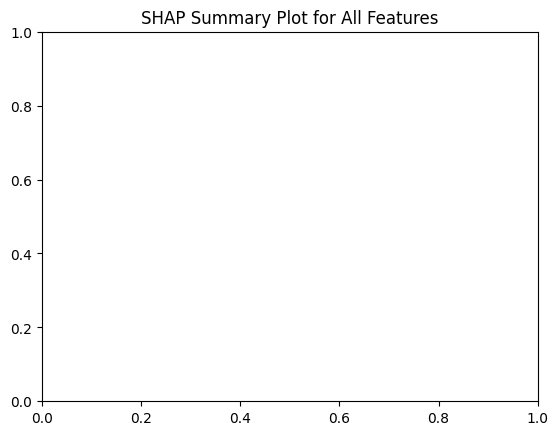

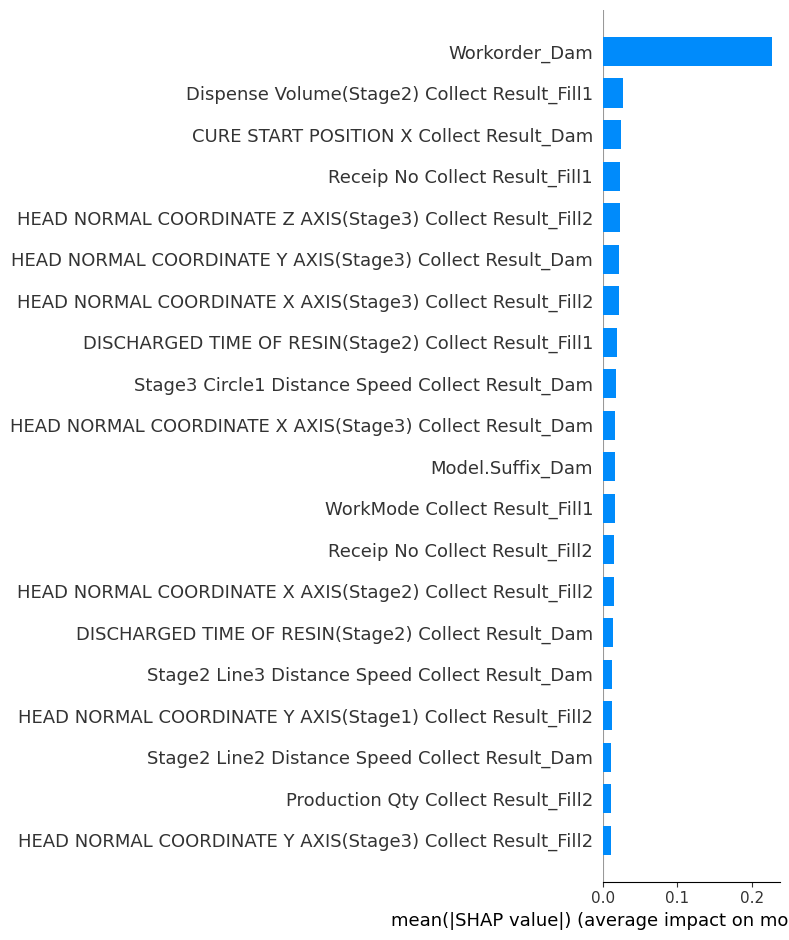

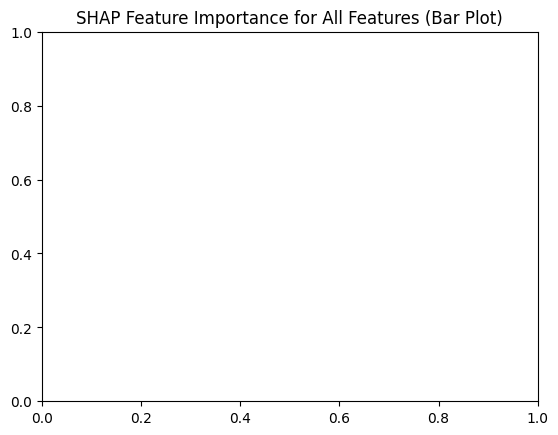

In [ ]:
import shap
from catboost import Pool
import matplotlib.pyplot as plt

# 전체 피처를 사용하여 Pool 객체 생성
full_pool = Pool(data=X, feature_names=X.columns.tolist(), cat_features=cat_features)

# SHAP Explainer 생성
explainer = shap.TreeExplainer(model)

# SHAP 값 계산
shap_values = explainer.shap_values(full_pool)

# SHAP Summary Plot (Dot Plot)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X)
plt.title("SHAP Summary Plot for All Features")
plt.show()

# SHAP Summary Plot (Bar Plot)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X, plot_type="bar")
plt.title("SHAP Feature Importance for All Features (Bar Plot)")
plt.show()

In [ ]:
# Predicting on test data
test_pool = Pool(X_test, cat_features=cat_features)
test_predictions_proba = model.predict_proba(test_pool)[:, 1]
test_predictions = (test_predictions_proba > 0.6).astype(int)

# Mapping predictions back to original values
test_predictions = pd.Series(test_predictions).map(inverse_target_mapping)
test_predictions.value_counts()

Normal      14686
AbNormal     2675
Name: count, dtype: int64

In [ ]:
# Saving predictions to a CSV file with the desired format
submission = pd.DataFrame({'Set ID': test_df['Set ID'], 'target': test_predictions})
submission.to_csv('submission.csv', index=False)

print("Test predictions saved to test_predictions.csv")

Test predictions saved to test_predictions.csv
